In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                  activation='relu')) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))         
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 5333, 64)          12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 5333, 64)          12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3342 - acc: 0.2681
Epoch 00001: val_loss improved from inf to 2.11902, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_1_conv_checkpoint/001-2.1190.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.3342 - acc: 0.2680 - val_loss: 2.1190 - val_acc: 0.3361
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8677 - acc: 0.4412
Epoch 00002: val_loss improved from 2.11902 to 1.97704, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_1_conv_checkpoint/002-1.9770.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.8677 - acc: 0.4411 - val_loss: 1.9770 - val_acc: 0.3946
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4978 - acc: 0.5650
Epoch 00003: val_loss did not improve from 1.97704
36805/3680

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9967
Epoch 00029: val_loss did not improve from 1.97704
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0339 - acc: 0.9967 - val_loss: 4.6855 - val_acc: 0.3627
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0350 - acc: 0.9958
Epoch 00030: val_loss did not improve from 1.97704
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0350 - acc: 0.9958 - val_loss: 4.6992 - val_acc: 0.3657
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9970
Epoch 00031: val_loss did not improve from 1.97704
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0310 - acc: 0.9970 - val_loss: 4.7316 - val_acc: 0.3604
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0310 - acc: 0.9963
Epoch 00032: val_loss did not improve from 1.97704
36805/36805 [===========

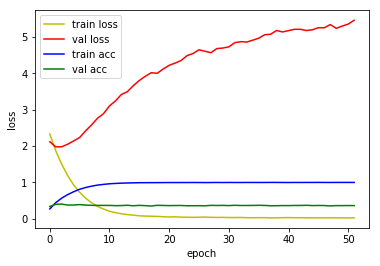

4815/4815 [==============================] - 2s 465us/sample - loss: 1.9917 - acc: 0.3877
Loss: 1.9917109709043492 Accuracy: 0.38774663

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2231 - acc: 0.3038
Epoch 00001: val_loss improved from inf to 1.88607, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_2_conv_checkpoint/001-1.8861.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 2.2230 - acc: 0.3039 - val_loss: 1.8861 - val_acc: 0.4386
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7233 - acc: 0.4796
Epoch 00002: val_loss improved from 1.88607 to 1.68747, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_2_conv_checkpoint/002-1.6875.hdf5
36805/36805 [==============================] - 71s 2ms/sample - loss: 1.7232 - acc: 0.4797 - val_loss: 1.6875 - val_acc: 0.4908
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0650 - acc: 0.9839
Epoch 00029: val_loss did not improve from 1.64934
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.0650 - acc: 0.9839 - val_loss: 3.8565 - val_acc: 0.4857
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0517 - acc: 0.9885
Epoch 00030: val_loss did not improve from 1.64934
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0517 - acc: 0.9885 - val_loss: 3.9517 - val_acc: 0.4845
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0583 - acc: 0.9870
Epoch 00031: val_loss did not improve from 1.64934
36805/36805 [==============================] - 71s 2ms/sample - loss: 0.0583 - acc: 0.9870 - val_loss: 3.8449 - val_acc: 0.4819
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0525 - acc: 0.9884
Epoch 00032: val_loss did not improve from 1.64934
36805/36805 [===========

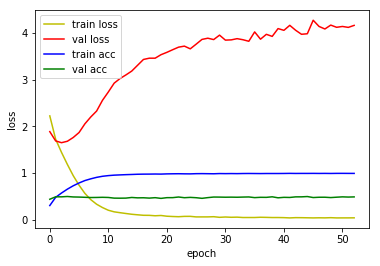

4815/4815 [==============================] - 4s 769us/sample - loss: 1.7163 - acc: 0.4752
Loss: 1.7163452906276826 Accuracy: 0.47518173

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2427 - acc: 0.2877
Epoch 00001: val_loss improved from inf to 1.86165, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_3_conv_checkpoint/001-1.8617.hdf5
36805/36805 [==============================] - 83s 2ms/sample - loss: 2.2427 - acc: 0.2876 - val_loss: 1.8617 - val_acc: 0.4088
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6555 - acc: 0.4901
Epoch 00002: val_loss improved from 1.86165 to 1.58989, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_3_conv_checkpoint/002-1.5899.hdf5
36805/36805 [==============================] - 81s 2ms/sample - loss: 1.6555 - acc: 0.4901 - val_loss: 1.5899 - val_acc: 0.5236
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1024 - acc: 0.9709
Epoch 00029: val_loss did not improve from 1.36893
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.1023 - acc: 0.9709 - val_loss: 2.3492 - val_acc: 0.6189
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0927 - acc: 0.9735
Epoch 00030: val_loss did not improve from 1.36893
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0929 - acc: 0.9734 - val_loss: 2.4099 - val_acc: 0.6205
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0977 - acc: 0.9722
Epoch 00031: val_loss did not improve from 1.36893
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.0977 - acc: 0.9722 - val_loss: 2.3612 - val_acc: 0.6236
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0906 - acc: 0.9758
Epoch 00032: val_loss did not improve from 1.36893
36805/36805 [===========

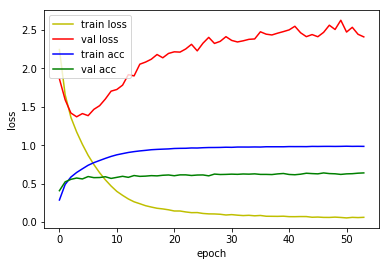

4815/4815 [==============================] - 4s 859us/sample - loss: 1.4290 - acc: 0.5626
Loss: 1.4289896430008633 Accuracy: 0.5626168

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1544 - acc: 0.3033
Epoch 00001: val_loss improved from inf to 1.62908, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_4_conv_checkpoint/001-1.6291.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 2.1543 - acc: 0.3033 - val_loss: 1.6291 - val_acc: 0.4754
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4514 - acc: 0.5414
Epoch 00002: val_loss improved from 1.62908 to 1.26991, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_4_conv_checkpoint/002-1.2699.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 1.4514 - acc: 0.5414 - val_loss: 1.2699 - val_acc: 0.6147
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1376 - acc: 0.9565
Epoch 00028: val_loss did not improve from 0.97701
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1376 - acc: 0.9566 - val_loss: 1.2277 - val_acc: 0.7543
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1328 - acc: 0.9587
Epoch 00029: val_loss did not improve from 0.97701
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1328 - acc: 0.9587 - val_loss: 1.2834 - val_acc: 0.7463
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1254 - acc: 0.9594
Epoch 00030: val_loss did not improve from 0.97701
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.1254 - acc: 0.9594 - val_loss: 1.2573 - val_acc: 0.7512
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1272 - acc: 0.9601
Epoch 00031: val_loss did not improve from 0.97701
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0742 - acc: 0.9769
Epoch 00058: val_loss did not improve from 0.97701
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0742 - acc: 0.9769 - val_loss: 1.3651 - val_acc: 0.7624

1D_CNN_custom_conv_3_VGG_DO_4_conv Model


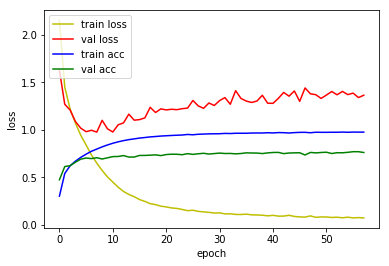

4815/4815 [==============================] - 4s 890us/sample - loss: 1.0904 - acc: 0.6719
Loss: 1.0903628553928244 Accuracy: 0.6718588

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1243 - acc: 0.3067
Epoch 00001: val_loss improved from inf to 1.55428, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_5_conv_checkpoint/001-1.5543.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 2.1242 - acc: 0.3067 - val_loss: 1.5543 - val_acc: 0.4997
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4237 - acc: 0.5414
Epoch 00002: val_loss improved from 1.55428 to 1.27438, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_5_conv_checkpoint/002-1.2744.hdf5
36805/36805 [==============================] - 87s 2ms/sample - loss: 1.4237 - acc: 0.5413 - val_loss: 1.2744 - val_acc: 0.5954
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1489 - acc: 0.9517
Epoch 00027: val_loss did not improve from 0.73621
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1489 - acc: 0.9517 - val_loss: 0.8396 - val_acc: 0.8171
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1438 - acc: 0.9524
Epoch 00028: val_loss did not improve from 0.73621
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1439 - acc: 0.9524 - val_loss: 0.8545 - val_acc: 0.8116
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1403 - acc: 0.9550
Epoch 00029: val_loss did not improve from 0.73621
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.1403 - acc: 0.9550 - val_loss: 0.9271 - val_acc: 0.8039
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1310 - acc: 0.9588
Epoch 00030: val_loss did not improve from 0.73621
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0685 - acc: 0.9794
Epoch 00057: val_loss did not improve from 0.73621
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0685 - acc: 0.9794 - val_loss: 0.9247 - val_acc: 0.8337
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0680 - acc: 0.9796
Epoch 00058: val_loss did not improve from 0.73621
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0680 - acc: 0.9796 - val_loss: 0.9255 - val_acc: 0.8344
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0691 - acc: 0.9792
Epoch 00059: val_loss did not improve from 0.73621
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0690 - acc: 0.9792 - val_loss: 0.9196 - val_acc: 0.8307
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0715 - acc: 0.9788
Epoch 00060: val_loss did not improve from 0.73621
36805/36805 [===========

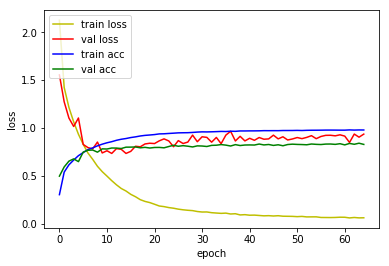

4815/4815 [==============================] - 5s 945us/sample - loss: 0.8833 - acc: 0.7666
Loss: 0.883316714778496 Accuracy: 0.7665628

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4018 - acc: 0.2090
Epoch 00001: val_loss improved from inf to 1.67515, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_6_conv_checkpoint/001-1.6752.hdf5
36805/36805 [==============================] - 94s 3ms/sample - loss: 2.4017 - acc: 0.2090 - val_loss: 1.6752 - val_acc: 0.4663
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5659 - acc: 0.4914
Epoch 00002: val_loss improved from 1.67515 to 1.34717, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_6_conv_checkpoint/002-1.3472.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.5657 - acc: 0.4914 - val_loss: 1.3472 - val_acc: 0.5840
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2694 - acc: 0.9154
Epoch 00024: val_loss improved from 0.38753 to 0.36484, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_6_conv_checkpoint/024-0.3648.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2694 - acc: 0.9154 - val_loss: 0.3648 - val_acc: 0.9059
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2552 - acc: 0.9205
Epoch 00025: val_loss did not improve from 0.36484
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2552 - acc: 0.9205 - val_loss: 0.3684 - val_acc: 0.9061
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2361 - acc: 0.9248
Epoch 00026: val_loss improved from 0.36484 to 0.36309, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_6_conv_checkpoint/026-0.3631.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2361 - acc: 0.9248 - val_los

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0942 - acc: 0.9694
Epoch 00052: val_loss did not improve from 0.35622
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0942 - acc: 0.9694 - val_loss: 0.4090 - val_acc: 0.9231
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1004 - acc: 0.9667
Epoch 00053: val_loss did not improve from 0.35622
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1004 - acc: 0.9667 - val_loss: 0.4178 - val_acc: 0.9208
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0944 - acc: 0.9683
Epoch 00054: val_loss did not improve from 0.35622
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0944 - acc: 0.9683 - val_loss: 0.3780 - val_acc: 0.9213
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0860 - acc: 0.9720
Epoch 00055: val_loss did not improve from 0.35622
36805/36805 [===========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0548 - acc: 0.9826
Epoch 00082: val_loss did not improve from 0.35622
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0548 - acc: 0.9826 - val_loss: 0.4204 - val_acc: 0.9206
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0546 - acc: 0.9821
Epoch 00083: val_loss did not improve from 0.35622
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0546 - acc: 0.9821 - val_loss: 0.4875 - val_acc: 0.9154
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0591 - acc: 0.9806
Epoch 00084: val_loss did not improve from 0.35622
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0591 - acc: 0.9806 - val_loss: 0.4242 - val_acc: 0.9248
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0563 - acc: 0.9821
Epoch 00085: val_loss did not improve from 0.35622
36805/36805 [===========

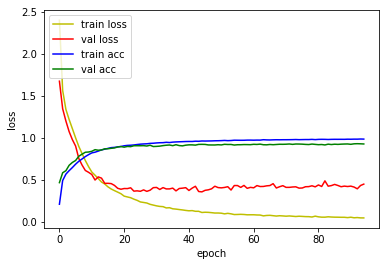

4815/4815 [==============================] - 5s 970us/sample - loss: 0.4131 - acc: 0.9018
Loss: 0.41305809186255077 Accuracy: 0.9017653

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5060 - acc: 0.1717
Epoch 00001: val_loss improved from inf to 1.94137, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_7_conv_checkpoint/001-1.9414.hdf5
36805/36805 [==============================] - 97s 3ms/sample - loss: 2.5060 - acc: 0.1717 - val_loss: 1.9414 - val_acc: 0.3638
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6701 - acc: 0.4447
Epoch 00002: val_loss improved from 1.94137 to 1.24963, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_7_conv_checkpoint/002-1.2496.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.6702 - acc: 0.4446 - val_loss: 1.2496 - val_acc: 0.6052
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0930 - acc: 0.9694
Epoch 00051: val_loss did not improve from 0.15373
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0930 - acc: 0.9694 - val_loss: 0.1642 - val_acc: 0.9550
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0915 - acc: 0.9691
Epoch 00052: val_loss did not improve from 0.15373
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0915 - acc: 0.9691 - val_loss: 0.1667 - val_acc: 0.9583
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0877 - acc: 0.9708
Epoch 00053: val_loss did not improve from 0.15373
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0877 - acc: 0.9708 - val_loss: 0.1721 - val_acc: 0.9550
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0907 - acc: 0.9696
Epoch 00054: val_loss did not improve from 0.15373
36805/36805 [========================

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0550 - acc: 0.9820
Epoch 00081: val_loss did not improve from 0.15373
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0550 - acc: 0.9820 - val_loss: 0.1749 - val_acc: 0.9611
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0503 - acc: 0.9834
Epoch 00082: val_loss did not improve from 0.15373
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0503 - acc: 0.9834 - val_loss: 0.1996 - val_acc: 0.9616
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0526 - acc: 0.9814
Epoch 00083: val_loss did not improve from 0.15373
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0526 - acc: 0.9814 - val_loss: 0.1830 - val_acc: 0.9592
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0516 - acc: 0.9823
Epoch 00084: val_loss did not improve from 0.15373
36805/36805 [===========

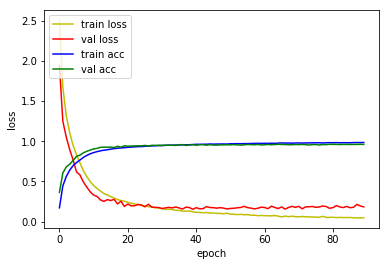

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2009 - acc: 0.9427
Loss: 0.20089558003352315 Accuracy: 0.9426791

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5030 - acc: 0.1666
Epoch 00001: val_loss improved from inf to 1.77017, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_8_conv_checkpoint/001-1.7702.hdf5
36805/36805 [==============================] - 101s 3ms/sample - loss: 2.5029 - acc: 0.1667 - val_loss: 1.7702 - val_acc: 0.4377
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5336 - acc: 0.4921
Epoch 00002: val_loss improved from 1.77017 to 1.02237, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_8_conv_checkpoint/002-1.0224.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.5335 - acc: 0.4921 - val_loss: 1.0224 - val_acc: 0.6776
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0717 - acc: 0.9754
Epoch 00050: val_loss did not improve from 0.10720
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0718 - acc: 0.9753 - val_loss: 0.1090 - val_acc: 0.9695
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0728 - acc: 0.9755
Epoch 00051: val_loss did not improve from 0.10720
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0728 - acc: 0.9755 - val_loss: 0.1210 - val_acc: 0.9690
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0670 - acc: 0.9774
Epoch 00052: val_loss did not improve from 0.10720
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0670 - acc: 0.9774 - val_loss: 0.1252 - val_acc: 0.9651
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0656 - acc: 0.9780
Epoch 00053: val_loss did not improve from 0.10720
36805/36805 [========================

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0372 - acc: 0.9870
Epoch 00080: val_loss did not improve from 0.10720
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0371 - acc: 0.9870 - val_loss: 0.1406 - val_acc: 0.9681
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0416 - acc: 0.9860
Epoch 00081: val_loss did not improve from 0.10720
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0416 - acc: 0.9860 - val_loss: 0.1220 - val_acc: 0.9702
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0376 - acc: 0.9878
Epoch 00082: val_loss did not improve from 0.10720
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0376 - acc: 0.9878 - val_loss: 0.1387 - val_acc: 0.9686
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9871
Epoch 00083: val_loss did not improve from 0.10720
36805/36805 [===========

Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0205 - acc: 0.9934
Epoch 00139: val_loss did not improve from 0.10587
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0205 - acc: 0.9934 - val_loss: 0.1362 - val_acc: 0.9720
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9937
Epoch 00140: val_loss did not improve from 0.10587
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0207 - acc: 0.9937 - val_loss: 0.1383 - val_acc: 0.9709
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0153 - acc: 0.9951
Epoch 00141: val_loss did not improve from 0.10587
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0153 - acc: 0.9951 - val_loss: 0.1399 - val_acc: 0.9711
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0190 - acc: 0.9941
Epoch 00142: val_loss did not improve from 0.10587
36805/36805 [=======

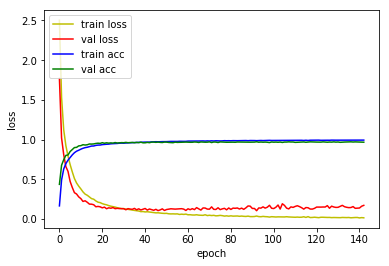

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1829 - acc: 0.9630
Loss: 0.18293105663304596 Accuracy: 0.9630322

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2604 - acc: 0.2589
Epoch 00001: val_loss improved from inf to 1.45279, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_9_conv_checkpoint/001-1.4528.hdf5
36805/36805 [==============================] - 104s 3ms/sample - loss: 2.2604 - acc: 0.2589 - val_loss: 1.4528 - val_acc: 0.5316
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2838 - acc: 0.5808
Epoch 00002: val_loss improved from 1.45279 to 0.93213, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_9_conv_checkpoint/002-0.9321.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.2837 - acc: 0.5808 - val_loss: 0.9321 - val_acc: 0.7009
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1053 - acc: 0.9652
Epoch 00025: val_loss improved from 0.16232 to 0.14835, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_9_conv_checkpoint/025-0.1484.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1054 - acc: 0.9652 - val_loss: 0.1484 - val_acc: 0.9539
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1038 - acc: 0.9655
Epoch 00026: val_loss did not improve from 0.14835
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1038 - acc: 0.9655 - val_loss: 0.1747 - val_acc: 0.9515
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0965 - acc: 0.9673
Epoch 00027: val_loss improved from 0.14835 to 0.14019, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_9_conv_checkpoint/027-0.1402.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0965 - acc: 0.9673 - val_los

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0349 - acc: 0.9881
Epoch 00054: val_loss did not improve from 0.14019
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0349 - acc: 0.9881 - val_loss: 0.1763 - val_acc: 0.9606
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9874
Epoch 00055: val_loss did not improve from 0.14019
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0379 - acc: 0.9874 - val_loss: 0.1862 - val_acc: 0.9576
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0320 - acc: 0.9899
Epoch 00056: val_loss did not improve from 0.14019
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0320 - acc: 0.9899 - val_loss: 0.1476 - val_acc: 0.9630
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0322 - acc: 0.9894
Epoch 00057: val_loss did not improve from 0.14019
36805/36805 [===========

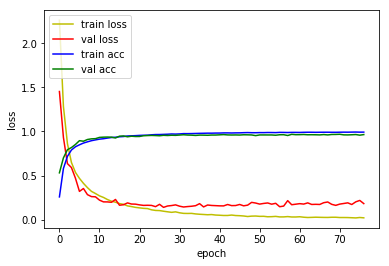

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2276 - acc: 0.9350
Loss: 0.2276410343955239 Accuracy: 0.9349948



In [10]:
for i in range(1, 10):
    model_name = '1D_CNN_custom_conv_3_VGG_DO_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 3s 556us/sample - loss: 1.9917 - acc: 0.387

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.8833 - acc: 0.7666
Loss: 0.883316714778496 Accuracy: 0.7665628

1D_CNN_custom_conv_3_VGG_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_124 (Conv1D)          (None

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1829 - acc: 0.9630
Loss: 0.18293105663304596 Accuracy: 0.9630322

1D_CNN_custom_conv_3_VGG_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_164 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_165 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_166 (Conv1D)          (No

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3996 - acc: 0.2123
Epoch 00001: val_loss improved from inf to 1.69751, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_6_conv_checkpoint/001-1.6975.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 2.3996 - acc: 0.2123 - val_loss: 1.6975 - val_acc: 0.4577
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5830 - acc: 0.4828
Epoch 00002: val_loss improved from 1.69751 to 1.44006, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_6_conv_checkpoint/002-1.4401.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.5829 - acc: 0.4828 - val_l

36800/36805 [============================>.] - ETA: 0s - loss: 0.3164 - acc: 0.9015
Epoch 00021: val_loss did not improve from 0.39175
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.3164 - acc: 0.9016 - val_loss: 0.3933 - val_acc: 0.8924
Epoch 22/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2963 - acc: 0.9091
Epoch 00022: val_loss improved from 0.39175 to 0.38238, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_6_conv_checkpoint/022-0.3824.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2964 - acc: 0.9091 - val_loss: 0.3824 - val_acc: 0.8968
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2844 - acc: 0.9132
Epoch 00023: val_loss improved from 0.38238 to 0.35920, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_6_conv_checkpoint/023-0.3592.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2845 - acc: 0.9131 - val_loss: 0.3592 - v

36800/36805 [============================>.] - ETA: 0s - loss: 0.1053 - acc: 0.9657
Epoch 00049: val_loss did not improve from 0.32931
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1053 - acc: 0.9657 - val_loss: 0.3819 - val_acc: 0.9203
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1035 - acc: 0.9657
Epoch 00050: val_loss did not improve from 0.32931
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1035 - acc: 0.9657 - val_loss: 0.3793 - val_acc: 0.9208
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1029 - acc: 0.9657
Epoch 00051: val_loss did not improve from 0.32931
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1029 - acc: 0.9657 - val_loss: 0.3977 - val_acc: 0.9208
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1012 - acc: 0.9675
Epoch 00052: val_loss did not improve from 0.32931
36805/36805 [========================

Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0592 - acc: 0.9810
Epoch 00079: val_loss did not improve from 0.32931
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0596 - acc: 0.9809 - val_loss: 0.3883 - val_acc: 0.9317
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0638 - acc: 0.9798
Epoch 00080: val_loss did not improve from 0.32931
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0638 - acc: 0.9798 - val_loss: 0.3781 - val_acc: 0.9292
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0592 - acc: 0.9810
Epoch 00081: val_loss did not improve from 0.32931
36805/36805 [==============================] - 87s 2ms/sample - loss: 0.0592 - acc: 0.9810 - val_loss: 0.4343 - val_acc: 0.9259
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0554 - acc: 0.9829
Epoch 00082: val_loss did not improve from 0.32931
36805/36805 [===========

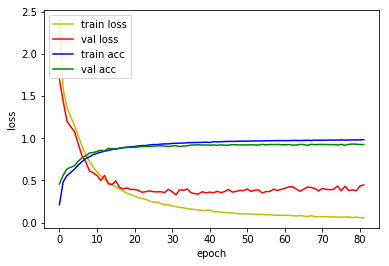

4815/4815 [==============================] - 5s 952us/sample - loss: 0.3998 - acc: 0.8955
Loss: 0.39981899699689444 Accuracy: 0.8955348

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4949 - acc: 0.1770
Epoch 00001: val_loss improved from inf to 1.76621, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_7_conv_checkpoint/001-1.7662.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 2.4948 - acc: 0.1770 - val_loss: 1.7662 - val_acc: 0.4160
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6554 - acc: 0.4478
Epoch 00002: val_loss improved from 1.76621 to 1.29319, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_7_conv_checkpoint/002-1.2932.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.6553 - acc: 0.4479 - val_loss: 1.2932 - val_acc: 0.5649
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2283 - acc: 0.9289
Epoch 00024: val_loss improved from 0.20793 to 0.19989, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_7_conv_checkpoint/024-0.1999.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2283 - acc: 0.9289 - val_loss: 0.1999 - val_acc: 0.9483
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2248 - acc: 0.9281
Epoch 00025: val_loss improved from 0.19989 to 0.19974, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_7_conv_checkpoint/025-0.1997.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2248 - acc: 0.9281 - val_loss: 0.1997 - val_acc: 0.9450
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2107 - acc: 0.9321
Epoch 00026: val_loss did not improve from 0.19974
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2107 - acc: 0.9321 - val_los

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0969 - acc: 0.9671
Epoch 00051: val_loss did not improve from 0.15809
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0969 - acc: 0.9671 - val_loss: 0.2147 - val_acc: 0.9443
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0956 - acc: 0.9677
Epoch 00052: val_loss did not improve from 0.15809
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0956 - acc: 0.9677 - val_loss: 0.1616 - val_acc: 0.9569
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0976 - acc: 0.9672
Epoch 00053: val_loss did not improve from 0.15809
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0976 - acc: 0.9672 - val_loss: 0.1650 - val_acc: 0.9592
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0915 - acc: 0.9690
Epoch 00054: val_loss did not improve from 0.15809
36805/36805 [===========

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0631 - acc: 0.9794
Epoch 00081: val_loss did not improve from 0.15809
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0631 - acc: 0.9794 - val_loss: 0.1873 - val_acc: 0.9599
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0522 - acc: 0.9821
Epoch 00082: val_loss did not improve from 0.15809
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0522 - acc: 0.9821 - val_loss: 0.1843 - val_acc: 0.9616
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0561 - acc: 0.9809
Epoch 00083: val_loss did not improve from 0.15809
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0561 - acc: 0.9809 - val_loss: 0.1727 - val_acc: 0.9620
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0488 - acc: 0.9837
Epoch 00084: val_loss did not improve from 0.15809
36805/36805 [===========

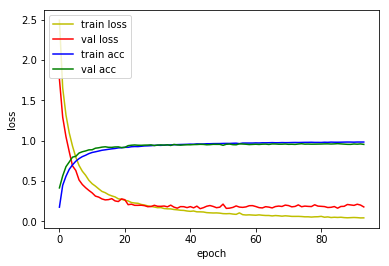

4815/4815 [==============================] - 5s 978us/sample - loss: 0.1860 - acc: 0.9450
Loss: 0.18600267374178206 Accuracy: 0.94496363

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4622 - acc: 0.1899
Epoch 00001: val_loss improved from inf to 1.81917, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_8_conv_checkpoint/001-1.8192.hdf5
36805/36805 [==============================] - 96s 3ms/sample - loss: 2.4621 - acc: 0.1899 - val_loss: 1.8192 - val_acc: 0.4062
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5126 - acc: 0.5037
Epoch 00002: val_loss improved from 1.81917 to 0.99189, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_8_conv_checkpoint/002-0.9919.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.5125 - acc: 0.5038 - val_loss: 0.9919 - val_acc: 0.6818
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1851 - acc: 0.9406
Epoch 00023: val_loss did not improve from 0.14972
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1851 - acc: 0.9406 - val_loss: 0.1606 - val_acc: 0.9497
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1772 - acc: 0.9412
Epoch 00024: val_loss improved from 0.14972 to 0.14886, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_8_conv_checkpoint/024-0.1489.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1772 - acc: 0.9412 - val_loss: 0.1489 - val_acc: 0.9557
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1741 - acc: 0.9425
Epoch 00025: val_loss improved from 0.14886 to 0.13367, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_8_conv_checkpoint/025-0.1337.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1741 - acc: 0.9425 - val_loss: 0.1337 - v

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0766 - acc: 0.9740
Epoch 00050: val_loss did not improve from 0.10452
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0766 - acc: 0.9741 - val_loss: 0.1199 - val_acc: 0.9676
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0738 - acc: 0.9751
Epoch 00051: val_loss did not improve from 0.10452
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0737 - acc: 0.9751 - val_loss: 0.1482 - val_acc: 0.9651
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0758 - acc: 0.9738
Epoch 00052: val_loss did not improve from 0.10452
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0758 - acc: 0.9738 - val_loss: 0.1194 - val_acc: 0.9688
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0711 - acc: 0.9756
Epoch 00053: val_loss did not improve from 0.10452
36805/36805 [===========

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0392 - acc: 0.9866
Epoch 00080: val_loss did not improve from 0.10452
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0392 - acc: 0.9866 - val_loss: 0.1301 - val_acc: 0.9674
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0412 - acc: 0.9865
Epoch 00081: val_loss did not improve from 0.10452
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0412 - acc: 0.9865 - val_loss: 0.1346 - val_acc: 0.9695
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0385 - acc: 0.9870
Epoch 00082: val_loss did not improve from 0.10452
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0385 - acc: 0.9870 - val_loss: 0.1421 - val_acc: 0.9690
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0407 - acc: 0.9858
Epoch 00083: val_loss did not improve from 0.10452
36805/36805 [===========

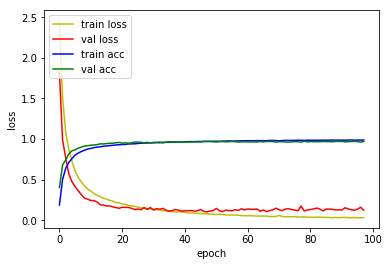

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1765 - acc: 0.9502
Loss: 0.17650031864349097 Accuracy: 0.95015574

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3490 - acc: 0.2313
Epoch 00001: val_loss improved from inf to 1.68440, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_9_conv_checkpoint/001-1.6844.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 2.3490 - acc: 0.2313 - val_loss: 1.6844 - val_acc: 0.4528
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4261 - acc: 0.5374
Epoch 00002: val_loss improved from 1.68440 to 0.94756, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_9_conv_checkpoint/002-0.9476.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.4261 - acc: 0.5374 - val_loss: 0.9476 - val_acc: 0.6879
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1181 - acc: 0.9605
Epoch 00024: val_loss did not improve from 0.14530
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1181 - acc: 0.9605 - val_loss: 0.1720 - val_acc: 0.9534
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1079 - acc: 0.9638
Epoch 00025: val_loss did not improve from 0.14530
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1079 - acc: 0.9638 - val_loss: 0.1493 - val_acc: 0.9546
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1007 - acc: 0.9671
Epoch 00026: val_loss did not improve from 0.14530
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1007 - acc: 0.9671 - val_loss: 0.1492 - val_acc: 0.9546
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0972 - acc: 0.9673
Epoch 00027: val_loss did not improve from 0.14530
36805/36805 [===========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0382 - acc: 0.9879
Epoch 00054: val_loss did not improve from 0.14530
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0382 - acc: 0.9879 - val_loss: 0.2183 - val_acc: 0.9604
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9881
Epoch 00055: val_loss did not improve from 0.14530
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0373 - acc: 0.9881 - val_loss: 0.1797 - val_acc: 0.9590
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0335 - acc: 0.9892
Epoch 00056: val_loss did not improve from 0.14530
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0335 - acc: 0.9892 - val_loss: 0.1707 - val_acc: 0.9634
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0332 - acc: 0.9888
Epoch 00057: val_loss did not improve from 0.14530
36805/36805 [===========

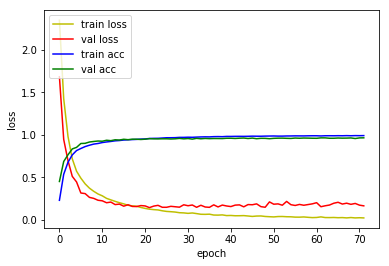

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2050 - acc: 0.9439
Loss: 0.2050418087843175 Accuracy: 0.94392526



In [9]:
for i in range(6, 10):
    base = '1D_CNN_custom_conv_3_VGG_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [10]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 3s 533us/sample - loss: 1.9976 - acc: 0.390

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.8236 - acc: 0.7593
Loss: 0.8235816266554044 Accuracy: 0.75929385

1D_CNN_custom_conv_3_VGG_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5333, 64)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (No

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1765 - acc: 0.9502
Loss: 0.17650031864349097 Accuracy: 0.95015574

1D_CNN_custom_conv_3_VGG_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_46 (Conv1D)           (N

In [11]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(1, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 3s 639us/sample - loss: 5.7123 - acc: 0.323

4815/4815 [==============================] - 6s 1ms/sample - loss: 1.0908 - acc: 0.7952
Loss: 1.0908317271546535 Accuracy: 0.79522324

1D_CNN_custom_conv_3_VGG_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5333, 64)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (No

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2163 - acc: 0.9551
Loss: 0.21633543381240192 Accuracy: 0.9551402

1D_CNN_custom_conv_3_VGG_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_46 (Conv1D)           (No